dddddddsdfdddd

### Importing Libraries

In [8]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize

from skimage.morphology import label
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [9]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


### Importing Dataset

In [12]:
im_width = 256
im_height = 256

image_filename_train = []

mask_files = glob(pathname='./lgg-mri-segmentation/kaggle_3m/*/*_mask*')
for i in mask_files:
    image_filename_train.append(i.replace('_mask',''))
print(image_filename_train[:10])
len(image_filename_train)

['./lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_18.tif', './lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_19.tif']


3929

In [13]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize  = (12,12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()

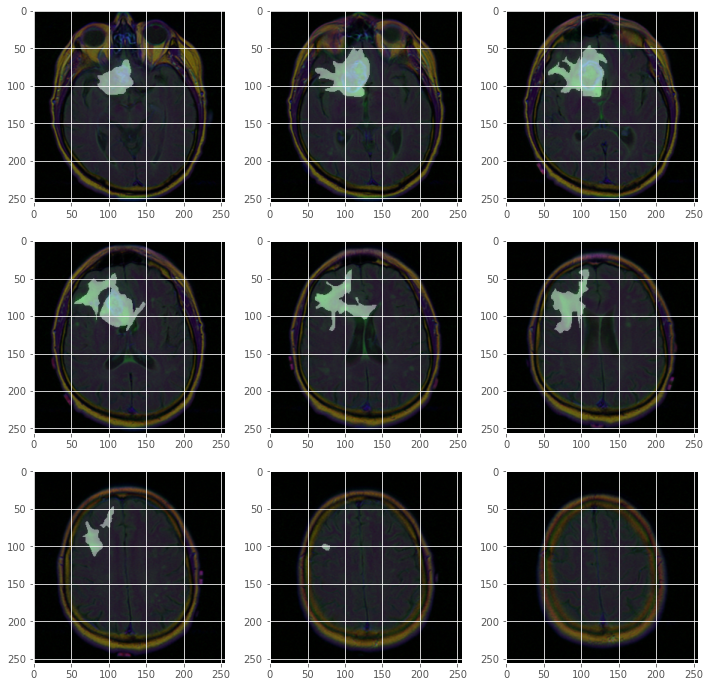

In [14]:
plot_from_img_path(3, 3, image_filename_train, mask_files)

### Preprocessing the Data

In [15]:
df = pd.DataFrame(data = {'image_filename_train': image_filename_train, 'mask': mask_files})
df_train, df_test = train_test_split(df, test_size = 0.05)
df_train, df_val = train_test_split(df_train, test_size = 0.05)

In [16]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(3545, 2)
(187, 2)
(197, 2)


In [31]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filename_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [32]:
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou
def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)

### UNet Architecture

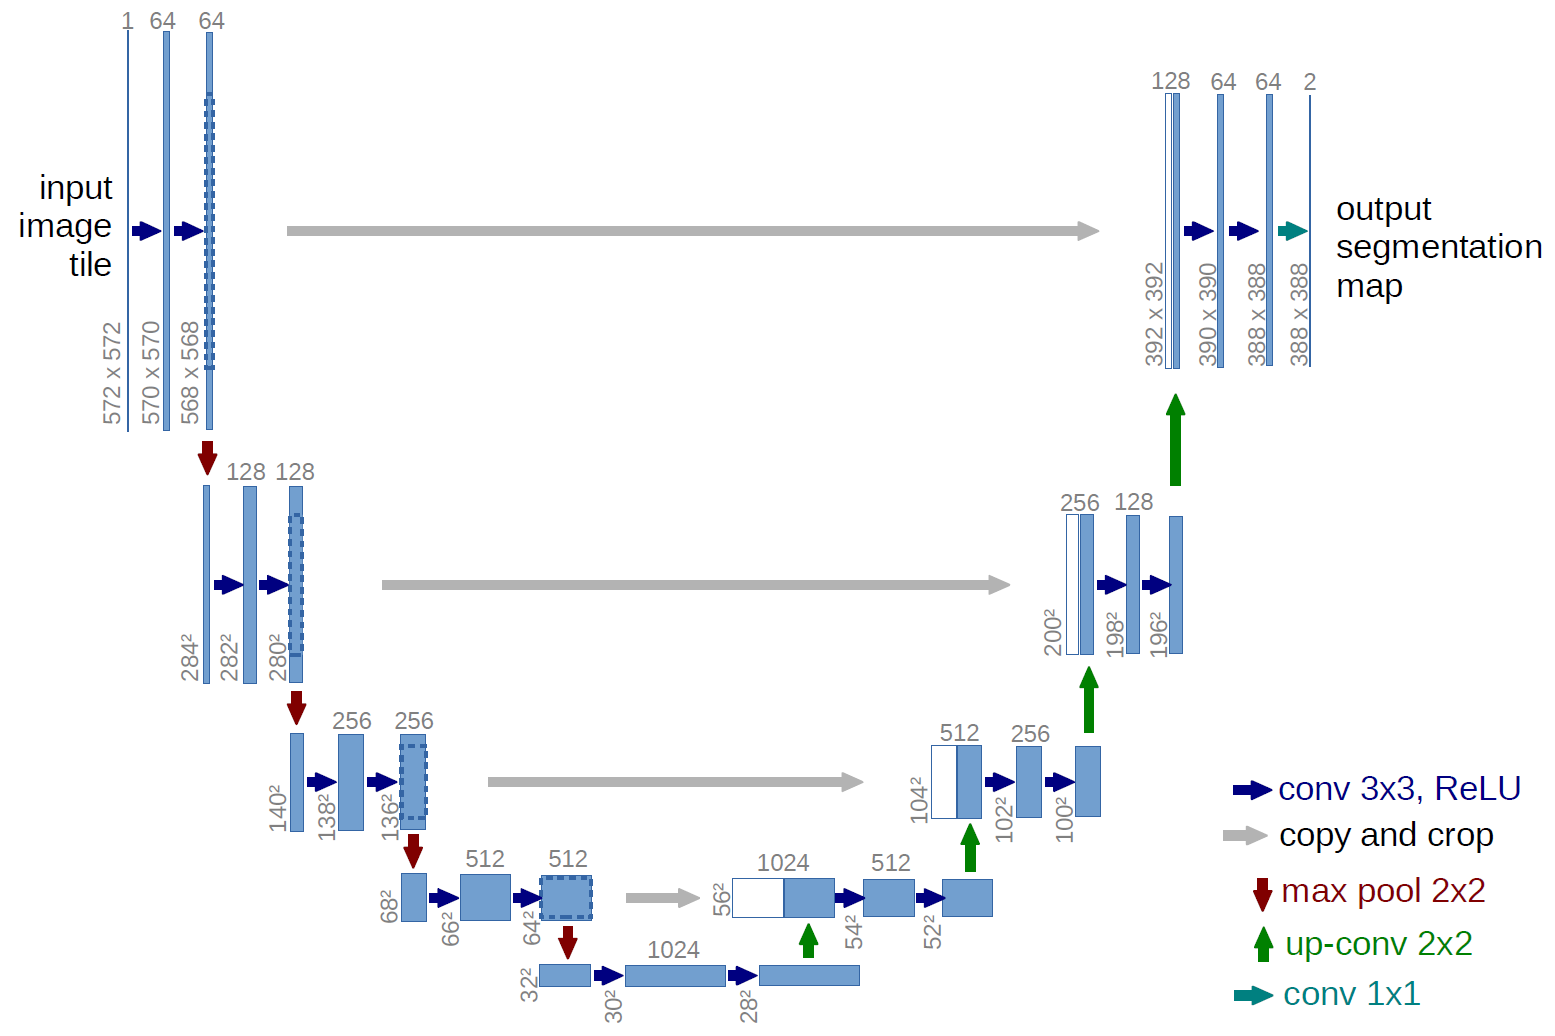

In [19]:
display(Image(filename='Unet_Architecture.png'))

In [20]:
def unet(input_size=(im_width, im_height, 3)):
    
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    # First DownSampling
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    #Second DownSampling
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
    # Third DownSampling
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6),conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7),conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8),conv1],axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

### Training the UNet model

In [21]:
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



# decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

/usr/lib/python3/dist-packages/keras/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 3545 validated image filenames.
Found 3545 validated image filenames.
Epoch 1/150
111/110 [==============================] - ETA: 0s - loss: -0.1441 - binary_accuracy: 0.9434 - iou: 0.0794 - dice_coefficients: 0.1441Found 187 validated image filenames.
Found 187 validated image filenames.

Epoch 1: val_loss improved from inf to -0.03032, saving model to unet_brain_mri_seg.hdf5


/usr/lib/python3/dist-packages/keras/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 73s 601ms/step - loss: -0.1441 - binary_accuracy: 0.9434 - iou: 0.0794 - dice_coefficients: 0.1441 - val_loss: -0.0303 - val_binary_accuracy: 0.9861 - val_iou: 0.0155 - val_dice_coefficients: 0.0304
Epoch 2/150
111/110 [==============================] - ETA: 0s - loss: -0.2453 - binary_accuracy: 0.9879 - iou: 0.1418 - dice_coefficients: 0.2454
Epoch 2: val_loss improved from -0.03032 to -0.03431, saving model to unet_brain_mri_seg.hdf5
110/110 [==============================] - 61s 557ms/step - loss: -0.2453 - binary_accuracy: 0.9879 - iou: 0.1418 - dice_coefficients: 0.2454 - val_loss: -0.0343 - val_binary_accuracy: 0.9875 - val_iou: 0.0177 - val_dice_coefficients: 0.0342
Epoch 3/150
111/110 [==============================] - ETA: 0s - loss: -0.3122 - binary_accuracy: 0.9909 - iou: 0.1883 - dice_coefficients: 0.3124
Epoch 3: val_loss improved from -0.03431 to -0.11296, saving model to unet_brain_mri_seg.hdf5
110/110 [=========================

### Plotting the metrics

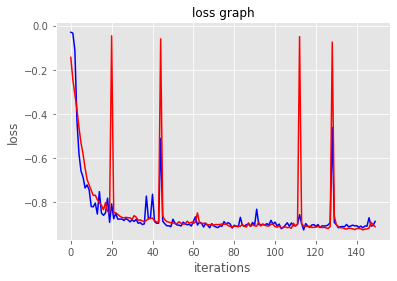

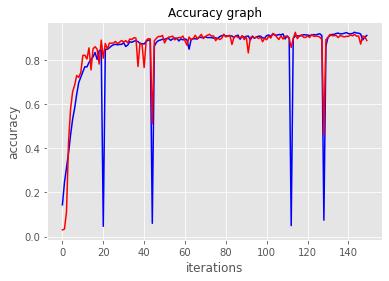

In [33]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

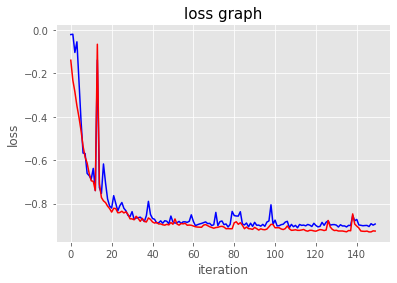

In [34]:
display(Image(filename='Loss Graph.png'))

### Evaluating the Model

In [46]:
from tensorflow.keras.models import load_model


model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coefficients_loss, 'iou': iou, 'dice_coef': dice_coefficients})

ValueError: Unknown loss function: 'dice_coefficients_loss'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height,im_width))

results = model.evaluate(test_gen, steps = len(df_test)/BATCH_SIZE)
print('Test Loss', results[0])
print('Test IOU', results[1])
print('Test Dice Coeff', results[2])

### Moment of Truth

In [ ]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filename_train'].iloc[index])
    img = cv2.resize(img, (im_height,im_width))
    img = img/255
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5)
    plt.title("Prediction")
    plt.show()